In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import nltk

import re
import spacy
from bs4 import BeautifulSoup
import spacy

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch.nn.functional as F

In [276]:
df = pd.read_csv("../data/TeleAntiFraud/cleaned_data.csv")
df = df[:50]

In [277]:
df = df[['conversation_id', 'fraud_type', 'perp_text_en']]
df.rename(columns={'perp_text_en': 'text', 'fraud_type': 'type', 'conversation_id': 'id'}, inplace=True)
df.reset_index(drop=True, inplace=True)
df['id'] = range(1, len(df) + 1)
df.set_index('id', inplace=True)

df['type'] = np.where(df['type'].isna(), 'No Scam', df['type'])

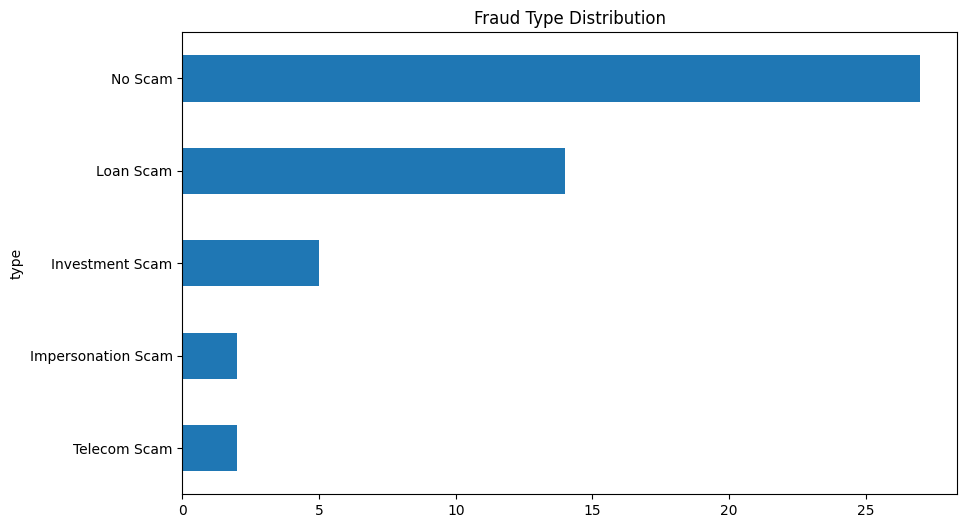

count      50.000000
mean      607.460000
std       264.529942
min       203.000000
25%       376.000000
50%       613.000000
75%       842.000000
max      1263.000000
Name: text_length, dtype: float64

In [278]:
df['type'].value_counts().sort_values().plot(kind='barh', figsize=(10, 6), title='Fraud Type Distribution')
plt.show()
# Text length distribution
df['text_length'] = df['text'].apply(len)
df['text_length'].describe()

In [279]:
MODEL1 = "ProsusAI/finbert"
tokenizer1 = AutoTokenizer.from_pretrained(MODEL1)
model1 = AutoModelForSequenceClassification.from_pretrained(MODEL1)

In [280]:
MODEL2 = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer2 = AutoTokenizer.from_pretrained(MODEL2, use_fast=False)
model2 = AutoModelForSequenceClassification.from_pretrained(
    MODEL2
)

In [281]:
tokenizer = tokenizer2

In [282]:
nlp = spacy.load('en_core_web_sm')

In [283]:
def clean_text(text):
    """Clean and normalize text for sentiment analysis."""
    text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)       # URLs
    text = re.sub(r"\S+@\S+", " ", text)                       # emails
    text = re.sub(r"\$[A-Za-z]{1,5}\b", " ", text)  

    text = text.replace("%", " percent ")
    text = re.sub(r"[-–]", " ", text)                          # dash normalization
    text = re.sub(r"[^A-Za-z0-9.,!? ]+", " ", text)            # remove emojis/symbols
    text = re.sub(r"\s+", " ", text).strip() 

    text = text.lower()

    return text

def polarity_scores(text, tokenizer_arg=None, model_arg=None, max_length=512):
    """
    Get sentiment scores using DistilBERT SST-2.
    Returns negative and positive probabilities.
    """
    # Use global tokenizer2 and model2 if not provided
    if tokenizer_arg is None:
        tokenizer_arg = tokenizer2  # Reference the global tokenizer2
    if model_arg is None:
        model_arg = model2  # Reference the global model2
    
    # Tokenize with proper parameters
    encoded_text = tokenizer_arg(
        text, 
        return_tensors='pt',
        truncation=True,
        # max_length=max_length,
        padding='max_length'
    )
    
    # Run inference
    with torch.no_grad():
        output = model_arg(**encoded_text)
    
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores, axis=0)
    
    scores_dict = {
        'sentiment_neg': float(scores[0]),  # Negative (potentially fraudulent)
        'sentiment_pos': float(scores[1])   # Positive (potentially legitimate)
    }
    return scores_dict

def add_sentiment_scores(df, text_column='cleaned_text'):
    """Add DistilBERT sentiment scores to dataframe."""
    sentiment_df = df[text_column].apply(polarity_scores).apply(pd.Series)
    
    df['sentiment_neg'] = sentiment_df['sentiment_neg']
    df['sentiment_pos'] = sentiment_df['sentiment_pos']
    
    return df

def add_dominant_sentiment(df):
    """Add dominant sentiment."""
    df['dominant_sentiment'] = df[['sentiment_neg', 'sentiment_pos']].idxmax(axis=1)
    df['dominant_sentiment'] = df['dominant_sentiment'].str.replace('sentiment_', '')
    df['sentiment_score'] = df[['sentiment_neg', 'sentiment_pos']].max(axis=1)
    
    # Map to fraud prediction
    df['fraud_prediction'] = df['dominant_sentiment'].map({
        'neg': 'Potential Fraud',
        'pos': 'Likely Legitimate'
    })
    
    return df

def process_sentiment_analysis(df, text_column='text', verbose=True):
    """
    Main function to process sentiment analysis on text data.
    
    Performs the following steps:
    1. Cleans the text (removes URLs, emails, special characters, etc.)
    2. Calculates FinBERT sentiment scores (negative, neutral, positive)
    3. Determines dominant sentiment and max sentiment score
    
    Args:
        df: DataFrame containing text data
        text_column: Name of the column containing the raw text (default: 'text')
        verbose: Whether to print progress messages (default: True)
    
    Returns:
        DataFrame with added columns:
            - cleaned_text: Cleaned and normalized text
            - finbert_neg: Negative sentiment probability
            - finbert_neu: Neutral sentiment probability  
            - finbert_pos: Positive sentiment probability
            - dominant_sentiment: The dominant sentiment (neg/neu/pos)
            - sentiment_score: The highest probability score
    """
    
    # Step 1: Clean the text
    df['cleaned_text'] = df[text_column].apply(clean_text)
    
    # Step 2: Add FinBERT sentiment score columns
    df = add_sentiment_scores(df, text_column='cleaned_text')
    
    # Step 3: Add dominant sentiment and sentiment score
    df = add_dominant_sentiment(df)
        
    return df

In [284]:
df = df[:50]

In [285]:
# Process sentiment analysis using the main function
df = process_sentiment_analysis(df, text_column='text', verbose=True)

In [286]:
df

,type,text,text_length,cleaned_text,sentiment_neg,sentiment_pos,dominant_sentiment,sentiment_score,fraud_prediction
id,,,,,,,,,
1,No Scam,"Hello, hello, I am the property manager of the...",828,"hello, hello, i am the property manager of the...",0.446601,0.553399,pos,0.553399,Likely Legitimate
2,No Scam,"Hello, this is the customer service of the foo...",879,"hello, this is the customer service of the foo...",0.945283,0.054717,neg,0.945283,Potential Fraud
3,Loan Scam,"Hello, hello, I am Manager Li, and this is the...",776,"hello, hello, i am manager li, and this is the...",0.014362,0.985638,pos,0.985638,Likely Legitimate
4,Telecom Scam,"Hello, hello, this is Taobao customer service....",846,"hello, hello, this is taobao customer service....",0.949376,0.050624,neg,0.949376,Potential Fraud
5,Investment Scam,"Hello, hello, I am a customer service speciali...",943,"hello, hello, i am a customer service speciali...",0.002714,0.997286,pos,0.997286,Likely Legitimate
6,Loan Scam,"Hello, hello, are you Miss Wang? I am a custom...",843,"hello, hello, are you miss wang? i am a custom...",0.078029,0.921971,pos,0.921971,Likely Legitimate
7,Loan Scam,"Hello, I am Xiao Li from Bank of China Credit ...",703,"hello, i am xiao li from bank of china credit ...",0.075747,0.924253,pos,0.924253,Likely Legitimate
8,No Scam,"Hey, um, I saw you have a house for rent, righ...",330,"hey, um, i saw you have a house for rent, righ...",0.002070,0.997930,pos,0.997930,Likely Legitimate
9,Impersonation Scam,"Hello, hello, is this Boss Zhang? I am Xiao Wa...",809,"hello, hello, is this boss zhang? i am xiao wa...",0.004755,0.995245,pos,0.995245,Likely Legitimate


1. Length of the text - usually smaller conversations are less scammy
2. Add some supplementary text to help the model - it senses sharp words like rise or fall 
3. Play around with the softmax outputs of neg, neu and pos scores and figure out patterns
4. Fine tune the model

In [287]:
polarity_scores(df['cleaned_text'].loc[50])

{'sentiment_neg': 0.3129754960536957, 'sentiment_pos': 0.6870245337486267}